In [8]:
import numpy as np
import sigpy as sp
import h5py

from aux import normalized_mse, get_args
from tqdm import tqdm as tqdm
from scipy.fft import ifft
from matplotlib import pyplot as plt

In [9]:
# Get arguments and hyper-parameters - by default optimized for CDL-A
snr_range = np.asarray(np.arange(-10, 17.5, 2.5)) 
alpha     = 0.6
num_steps = 1000 
lifting   = 4
lmbda     = 0.3
lr        = 3e-3
channel   = 'CDL-A'

In [10]:
# Number of tested samples - demo files have max. of 200
kept_samples = 10

# Global results
error_log = np.zeros((len(snr_range), num_steps, kept_samples))

In [11]:
# Load channels and pilots
target_file = 'data/%s_Nt64_Nr16_ULA0.50.h5' % channel
with h5py.File(target_file, 'r') as contents:
    H_gt = np.asarray(contents['H'])
    P    = np.asarray(contents['P'])
    # Downsample pilots
    P    = P[..., :int(H_gt.shape[-1] * alpha)]
    
# Perform global variance normalization of channels and get sizes
H_gt   = H_gt / np.std(H_gt)
Nr, Nt = H_gt.shape[1], H_gt.shape[2]

In [12]:
# Dictionary matrices for ULA
left_dict  = ifft(np.eye(Nr), n=Nr*lifting, norm='ortho').T
right_dict = np.conj(ifft(np.eye(Nt), n=Nt*lifting, norm='ortho'))

# Lifted shape and proximal op
lifted_shape = (Nr*lifting, Nt*lifting)
prox_op      = sp.prox.L1Reg(lifted_shape, lmbda)

In [ ]:
# For each SNR value
for snr_idx, snr in enumerate(snr_range):
    # Generate measurements
    Y = np.matmul(H_gt, P)
    Y = Y + np.sqrt(10 ** (-snr / 10.)) * np.sqrt(1/2) * (
        np.random.normal(size=Y.shape) + 1j * np.random.normal(size=Y.shape))
    
    # Solve for each sample
    for sample_idx in tqdm(range(kept_samples)):
        # Create forward and regularization ops
        # !!! This maps a channel matrix to the lifted 2D angular domain
        array_op = sp.linop.Compose(
            ((sp.linop.RightMatMul((lifted_shape[0], Nt), right_dict)),
            sp.linop.MatMul((Nr, Nt), left_dict)))
        
        # Forward operator maps angular domain to received symbols compactly
        # !!! Note the use of the adjoint for the previous operator
        fw_op  = sp.linop.Compose(
            (sp.linop.RightMatMul((Nr, Nt), P[sample_idx]),
             array_op.H))
        
        # Gradient of data consistency
        def gradf(x):
            return fw_op.H * (fw_op * x - Y[sample_idx])
        
        # Initializes from exact zero
        angles_hat = np.zeros(lifted_shape, complex)
        alg        = sp.alg.GradientMethod(
            gradf, angles_hat, lr, proxg=prox_op, max_iter=num_steps,
            accelerate=True)
        
        for step_idx in range(num_steps):
            alg.update()
            # Convert estimated angles to MIMO channel matrix
            est_H = array_op.H(angles_hat)
            
            # Log exact errors
            error_log[snr_idx, step_idx, sample_idx] = \
                normalized_mse(est_H, H_gt[sample_idx])

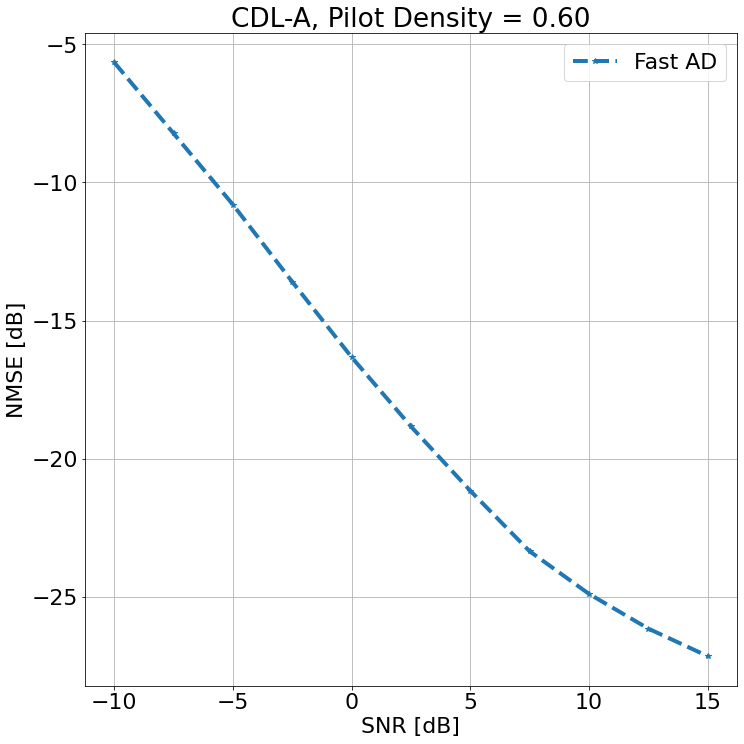

In [14]:
# Plot average NMSE as function of SNR, without early stopping
plt.rcParams['font.size'] = 22
plt.figure(figsize=(10.8, 10.8))
plt.plot(snr_range, 10 * np.log10(np.mean(error_log[:, -1], axis=-1)), 
         linewidth=4, marker='*', linestyle='dashed', label='Fast AD')
plt.xlabel('SNR [dB]'); plt.ylabel('NMSE [dB]'); plt.grid(); plt.legend()
plt.title('%s, Pilot Density = %.2f' % (channel, alpha))
plt.tight_layout()
plt.show()